In [2]:
import pandas as pd

/home/ian/jupyter/env3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ian/jupyter/env3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [8]:
train = pd.read_csv("train_imperson_without4n7_balanced_data.csv")

Delete columns that have zero variance

In [9]:
col_to_delete = [k for k in train.columns if train[k].std()==0]

Of which there are

In [10]:
len(col_to_delete)

74

In [11]:
train = train.drop(col_to_delete,axis=1)
trainX = train[train.columns[:-1]]
trainY = train["155"]

In [18]:
trainX0 = trainX[trainY==0]
trainX1 = trainX[trainY>0]

In [22]:
len(trainX)

97044

# Feature selection

Build a data table to hold information regarding the remaining variables

(Some `pandas` operations are easier if the feature name is a regular column but it's nice for that to be the index too)

In [35]:
features = pd.DataFrame(data = trainX.columns, columns = ['feature'], index = train.columns[:-1])

In [36]:
features["mu0"] = features.feature.apply(lambda f: trainX0[f].mean())
features["mu1"] = features.feature.apply(lambda f: trainX1[f].mean())

features["sigma0"] = features.feature.apply(lambda f: trainX0[f].std())
features["sigma1"] = features.feature.apply(lambda f: trainX1[f].std())

features["rho"] = features.feature.apply(lambda f: train[f].corr(train["155"]))

features.head()

,factor,mu0,mu1,sigma0,sigma1,rho
5,5,0.005345,0.007160,0.018728,0.011431,0.058410
6,6,0.005345,0.007160,0.018728,0.011431,0.058410
8,8,0.349147,0.038526,0.450527,0.006735,-0.438183
9,9,0.349147,0.038526,0.450527,0.006735,-0.438183
14,14,0.999567,1.000000,0.020799,0.000000,0.014712


## correlation

Sorting features by the absolute value of $\rho$, since a negative correlation is as predictive as a postive one

In [37]:
features["absrho"]=abs(features["rho"])

In [38]:
features.sort_values(by="absrho", ascending=False).loc[features["absrho"]>0.1]

,factor,mu0,mu1,sigma0,sigma1,rho,absrho
67,67,7.086695e-01,0.045289,0.260226,0.157740,-0.838937,0.838937
71,71,4.843164e-03,0.676456,0.069425,0.467833,0.708561,0.708561
50,50,4.031573e-01,0.999979,0.490537,0.004540,0.652165,0.652165
51,51,5.964099e-01,0.000021,0.490622,0.004540,-0.651828,0.651828
47,47,5.018176e-01,0.000022,0.450187,0.004542,-0.618997,0.618997
68,68,4.490540e-01,0.921829,0.470411,0.268404,0.525254,0.525254
38,38,6.591980e-01,0.768314,0.132439,0.024954,0.496848,0.496848
82,82,3.597495e-01,0.091727,0.329202,0.055956,-0.493602,0.493602
73,73,4.862330e-01,0.921870,0.499816,0.268378,0.477183,0.477183
146,146,5.687225e-02,0.000000,0.079131,0.000000,-0.453058,0.453058


## t-tests

t-tests establish the probability $p$ that we see a least that difference in the mean of a feature for the two conditions under the null hypothesis that they come from the same distribution

In [39]:
from scipy.stats import ttest_ind

In [40]:
features["t-test p"] = features.feature.apply(
    lambda f: ttest_ind(trainX0[f],
                        trainX1[f],
                        equal_var=False)[1]
)
features.head()

,factor,mu0,mu1,sigma0,sigma1,rho,absrho,t-test p
5,5,0.005345,0.007160,0.018728,0.011431,0.058410,0.058410,4.460255e-74
6,6,0.005345,0.007160,0.018728,0.011431,0.058410,0.058410,4.460255e-74
8,8,0.349147,0.038526,0.450527,0.006735,-0.438183,0.438183,0.000000e+00
9,9,0.349147,0.038526,0.450527,0.006735,-0.438183,0.438183,0.000000e+00
14,14,0.999567,1.000000,0.020799,0.000000,0.014712,0.014712,4.583503e-06


Sort from lowest probability

In [41]:
features.sort_values(by="t-test p")

,factor,mu0,mu1,sigma0,sigma1,rho,absrho,t-test p
154,154,0.334940,0.022008,0.458596,0.006407,-0.434536,0.434536,0.000000
94,94,0.055851,0.000289,0.229636,0.016984,-0.168196,0.168196,0.000000
77,77,0.038930,0.008852,0.095921,0.038162,-0.201783,0.201783,0.000000
75,75,0.005427,0.000290,0.011442,0.002490,-0.296245,0.296245,0.000000
73,73,0.486233,0.921870,0.499816,0.268378,0.477183,0.477183,0.000000
...,...,...,...,...,...,...,...,...
105,105,0.000021,0.000000,0.002780,0.000000,-0.005242,0.005242,0.102471
83,83,0.000041,0.000000,0.006420,0.000000,-0.004540,0.004540,0.157301
138,138,0.500008,0.500000,0.001725,0.000000,-0.003210,0.003210,0.317315
133,133,0.000021,0.000000,0.004540,0.000000,-0.003210,0.003210,0.317315


How many features have $p<0.05$?

In [28]:
len(features[features["t-test p"] < 0.05])

70

$p<0.000000001$?

In [56]:
len(features[features["t-test p"] < 0.000000001])

51

So most of the features have a significantly different mean under the two conditions

## unique values

Some features appear to only have a few values, eg

In [57]:
len(train["133"].unique())

2

Add a column to track the number of unique values a feature takes

In [58]:
features["vals"] = features.feature.apply(lambda f: len(train[f].unique()))

In [64]:
features.sort_values(by="vals").head(40)

,factor,mu0,mu1,sigma0,sigma1,rho,absrho,t-test p,vals
129,129,6.805573e-07,0.000000,0.000003,0.000000,-0.148360,0.148360,0.000000e+00,2
106,106,1.482495e-03,0.000018,0.035814,0.003934,-0.028733,0.028733,3.530465e-19,2
71,71,4.843164e-03,0.676456,0.069425,0.467833,0.708561,0.708561,0.000000e+00,2
72,72,1.978484e-03,0.000082,0.044437,0.009079,-0.029548,0.029548,3.419408e-20,2
73,73,4.862330e-01,0.921870,0.499816,0.268378,0.477183,0.477183,0.000000e+00,2
113,113,2.649747e-05,0.000000,0.003370,0.000000,-0.005560,0.005560,8.326452e-02,2
111,111,3.297473e-04,0.000577,0.018156,0.024015,0.005809,0.005809,7.037820e-02,2
133,133,2.060921e-05,0.000000,0.004540,0.000000,-0.003210,0.003210,3.173155e-01,2
83,83,4.121842e-05,0.000000,0.006420,0.000000,-0.004540,0.004540,1.573013e-01,2
84,84,1.236552e-04,0.000000,0.011119,0.000000,-0.007863,0.007863,1.430437e-02,2


There are a quite a few 2-value features, it might be worth looking at what proportion of the values for a feature are non-zero overall, and under each class

In [78]:
l = len(trainX)
l0 = len(trainX0)
l1 = len(trainX1)
features["nonzero"] = features.feature.apply(lambda f: len(trainX.loc[trainX[f]!=0])/l)
features["nonzero0"] = features.feature.apply(lambda f: len(trainX0.loc[trainX0[f]!=0])/l0)
features["nonzero1"] = features.feature.apply(lambda f: len(trainX1.loc[trainX1[f]!=0])/l1)

In [82]:
features.sort_values(by="nonzero").loc[features["nonzero"]<0.001]

,factor,mu0,mu1,sigma0,sigma1,rho,absrho,t-test p,vals,nonzero,nonzero0,nonzero1
97,97,0.000021,0.000000,0.004540,0.000000,-0.003210,0.003210,3.173155e-01,2,0.000010,0.000021,0.000000
133,133,0.000021,0.000000,0.004540,0.000000,-0.003210,0.003210,3.173155e-01,2,0.000010,0.000021,0.000000
83,83,0.000041,0.000000,0.006420,0.000000,-0.004540,0.004540,1.573013e-01,2,0.000021,0.000041,0.000000
105,105,0.000021,0.000000,0.002780,0.000000,-0.005242,0.005242,1.024710e-01,3,0.000031,0.000062,0.000000
113,113,0.000026,0.000000,0.003370,0.000000,-0.005560,0.005560,8.326452e-02,2,0.000031,0.000062,0.000000
88,88,0.000029,0.000000,0.003466,0.000000,-0.005912,0.005912,6.551449e-02,4,0.000062,0.000124,0.000000
84,84,0.000124,0.000000,0.011119,0.000000,-0.007863,0.007863,1.430437e-02,2,0.000062,0.000124,0.000000
86,86,0.000165,0.000000,0.012839,0.000000,-0.009080,0.009080,4.676670e-03,2,0.000082,0.000165,0.000000
117,117,0.000013,0.000000,0.001288,0.000000,-0.007129,0.007129,2.637066e-02,6,0.000082,0.000165,0.000000
111,111,0.000330,0.000577,0.018156,0.024015,0.005809,0.005809,7.037820e-02,2,0.000453,0.000330,0.000577


These features are extremely sparse, so may be noise.

Which features have good distribution, some correlation, and low p value?

In [168]:
features.loc[(features["nonzero"]>0.01) & (features["absrho"]>0.2) & (features["t-test p"]<0.01)].feature.values


array(['8', '9', '38', '47', '50', '51', '66', '67', '68', '70', '71',
       '73', '75', '77', '82', '110', '145', '146', '154'], dtype=object)

Parameterise this for ease of comparison later:

In [166]:
def feature_select(nonzero=0, absrho=0, ttestp=1):
    return features.loc[(features["nonzero"]>=nonzero) & (features["absrho"]>=absrho) & (features["t-test p"]<=ttestp)].feature.values

In [169]:
feature_set1 = feature_select(nonzero=0.01, absrho=0.2, ttestp=0.01)
feature_set1

array(['8', '9', '38', '47', '50', '51', '66', '67', '68', '70', '71',
       '73', '75', '77', '82', '110', '145', '146', '154'], dtype=object)

## baselining with logistic regression

Try this set of features in a logistic regression to get a baseline metric for evaluation.

Need to consider what is the most appropriate metric.

Is it more important to detect as many instrusions as possible (recall) or minimise false alarms (precision), or a balance like f1?

In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

Split the training data 60/40 into training and validation data

In [170]:
X_train, X_test, Y_train, Y_test = train_test_split(trainX[feature_set1], trainY, test_size=0.4)

In [245]:
# no regularisation at this point
lr = LogisticRegression(solver="sag", penalty='none').fit(X_train,Y_train)

/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [176]:
confusion_matrix(Y_test,lr.predict(X_test))

array([[18853,   461],
       [  172, 19332]])

In [210]:
def evaluate(model, ytest, xtest):
    pred = model.predict(xtest)
    p = precision_score(ytest,pred)
    r = recall_score(ytest,pred)
    f = f1_score(ytest,pred)
    return p,r,f

In [206]:
print(evaluate(lr, Y_test, X_test))

(0.9767089375031577, 0.9911812961443807, 0.9838919001450492, 1)


In [212]:
def thresholds_to_metrics(nonzero=0, absrho=0, ttestp=1):
    selection = feature_select(nonzero=nonzero, absrho=absrho, ttestp=ttestp)
    X_train, X_test, Y_train, Y_test = train_test_split(trainX[selection], trainY, test_size=0.4)
    lr = LogisticRegression(solver="sag", penalty='none').fit(X_train,Y_train)
    p,r,f = evaluate(lr, Y_test, X_test)
    return p,r,f,len(selection)

In [213]:
# no feature selection
thresholds_to_metrics()

/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


(0.9918225493202494, 0.9979943430187709, 0.9948988746763733, 78)

In [185]:
import matplotlib.pyplot as plt

Feature selection by p-value

/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


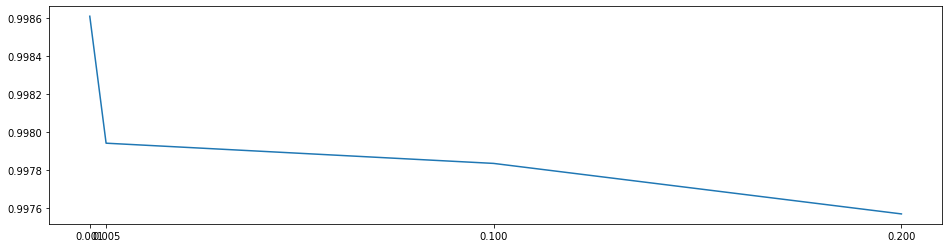

In [191]:
fig, ax = plt.subplots(figsize=(16,4))
ps = [0.2, 0.1, 0.005, 0.001]
ss = [thresholds_to_metrics(ttestp=p)[1] for p in ps]
ax.set_xticks(ps)
ax.plot(ps,ss)

By rho:

/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


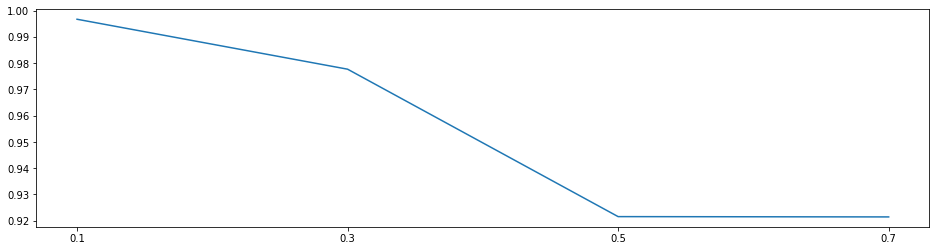

In [192]:
fig, ax = plt.subplots(figsize=(16,4))
rs = [0.1, 0.3, 0.5, 0.7]
ss = [thresholds_to_metrics(absrho=r)[1] for r in rs]
ax.set_xticks(rs)
ax.plot(rs,ss)

Proportion of nonzero values

/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


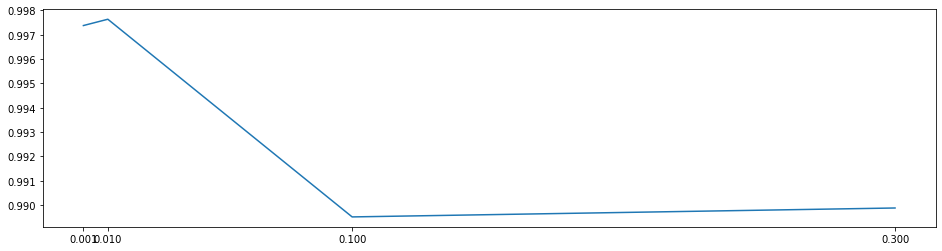

In [193]:
fig, ax = plt.subplots(figsize=(16,4))
ns = [0.001, 0.01, 0.1, 0.3]
ss = [thresholds_to_metrics(nonzero=n)[1] for n in ns]
ax.set_xticks(ns)
ax.plot(ns,ss)

In [214]:
thresholds_to_metrics(nonzero=0.01,absrho=0.1,ttestp=0.001)

/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


(0.9884593780319665, 0.9977835051546392, 0.9930995562168125, 31)

That's 99.8% recall from 31 features

Could look at size of coefficients as an indicator of importance..? Maybe something to pursue. Or could use random forest to get relative importances.

## PCA

Looks like some features are highly correlated, so perhaps PCA or clustering on features first.

In [215]:
from sklearn.decomposition import PCA

/home/ian/jupyter/env3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [228]:
X_train, X_test, Y_train, Y_test = train_test_split(trainX, trainY, test_size=0.4)

In [229]:
pca = PCA(n_components=20)

In [230]:
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

In [231]:
lr = LogisticRegression(solver='sag', penalty='none').fit(pca_train,Y_train)

/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [232]:
recall_score(Y_test, lr.predict(pca_test))

0.9975666580377944

Twenty component PCA does relatively well.

Let's look at a few more or fewer components. We can do that by taking say fifty and then keeping the first 5, 10, 20, 50 of them

In [233]:
pca = PCA(n_components=50)

In [234]:
X_train, X_test, Y_train, Y_test = train_test_split(trainX, trainY, test_size=0.4)

In [235]:
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

In [237]:
for pcs in [5,10,20,50]:
    lr = LogisticRegression(solver='sag', penalty='none').fit(pca_train[:,:pcs],Y_train)
    score = recall_score(Y_test, lr.predict(pca_test[:,:pcs]))
    print(f"{pcs}:\t{score}")

5:	0.9781322356573192


/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


10:	0.9947517365577566


/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


20:	0.9967584255209673
50:	0.9978904039104708


/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Looking closer at 1 to 20:

In [238]:
def principalcomponents_lrscore(n):
    lr = LogisticRegression(solver='sag', penalty='none').fit(pca_train[:,:n],Y_train)
    score = recall_score(Y_test, lr.predict(pca_test[:,:n]))
    return score

In [239]:
pcs = list(range(1,25,3))
lrs = [principalcomponents_lrscore(n) for n in pcs]

/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The ma

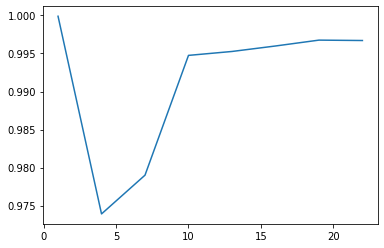

In [240]:
plt.plot(pcs, lrs)

Seems 10 or 20 are good choices

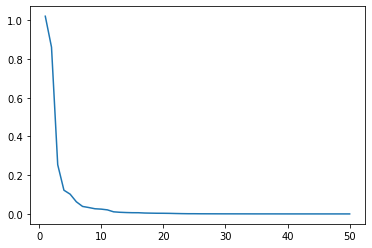

In [244]:
pca = PCA(n_components=50)
pca.fit(trainX)
plt.plot(range(1,51),pca.explained_variance_)